In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Exploratory Data Analysis (EDA)

The cleaned data was stored in ``bike_weather_daily.csv``. 
We plot daily bike usage as a time series.

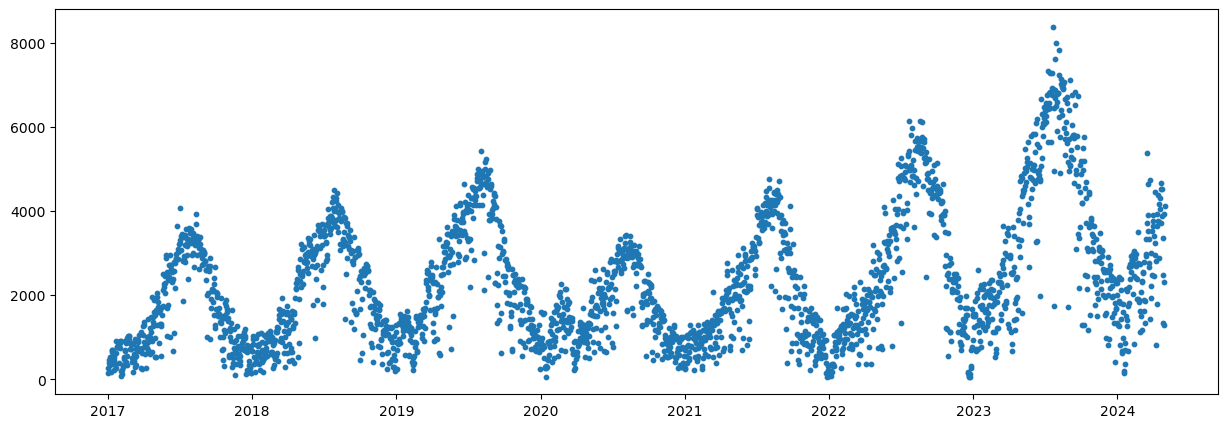

In [2]:
# The original cleaned data
df= pd.read_csv('bike_weather_daily.csv',parse_dates=['Date'])

# Re-index the data set using dates
df.set_index(df['Date'], inplace=True)
df.drop(columns=['Date'], inplace=True)

# Plot the number of bike uses as a time series
plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['num_trips'], s = 10)
plt.show()

As a time series, the data clearly demonstrates a trend and seasonality. We expect that the trend is due to the increasing demand for rental bikes per year (except for the 2020-2021 period, when COVID took place). Since the increasing trend is not reflected by any weather variables, we want to detrend the data to obtain a time series with no trend and only seasonality.

# Detrending

To find the trend, we need to remove seasonality. Our first estimate for seasonality is to simply repeat the 2017 data over and over. After removing the seasonality, we fit the trend using the following methods.

## Method 1: Using a degree 3 polynomial

The method is based on the following consideration: 

1. 3 is the minimal degree such that the polynomial can first increase, then decrease, and increase again. This accounts for the 2021 anomaly due to COVID.

2. A polynomial of degree 4 or more might cause overfitting, exacerbating the COVID effect, which might be unreliable for future predictions.

The detrended data was stored in ``bikeshare_train_data.csv``

In [3]:
train_df = pd.read_csv('bikeshare_train_data.csv',parse_dates=['Date'])

# Use dates as indices
train_df.set_index(train_df['Date'], inplace=True)
train_df.drop(columns=['Date'], inplace=True)

# Rename the column for the detrending method.
train_df.rename(columns={"adj_num_trips": "detrend_poly3"}, inplace =True)

## Method 2: Scale the COVID data and do an overall linear regression. 

After detrending the data using the previous method, the sine wave's amplitude during COVID is smaller than in other periods. . One might want to try scaling the COVID crest and performing a linear regressio Thisis detrending procedure was completed in the notebook ``Trend_Problem.ipynb``. The detrended data was stor e ``bikeshare_train_data_v1.csv``.

In [4]:
df2 = pd.read_csv('bikeshare_train_data_v1.csv',parse_dates=['Date'])

# Use dates as indices
df2.set_index(df2['Date'], inplace=True)

# Add the newly detrended data to the training set
train_df['detrend_scaling'] = df2['adj_num_trips']
train_df['trend_scaling'] = df2['trend']

## Method 3: Do two linear regressions: one pre-COVID and one after COVID. 

This detrending procedure was also completed in the notebook ``Trend_Problem.ipynb``. The detrended data was stored in the file ``bikeshare_train_data_v2.csv``.

In [5]:
df3 = pd.read_csv('bikeshare_train_data_v2.csv',parse_dates=['Date'])

# Use dates as indices
df3.set_index(df3['Date'], inplace=True)

# Add the newly detrended data to the training set
train_df['detrend_pcws'] = df3['adj_num_trips']
train_df['trend_pcws'] = df3['trend']

## Method 4: Detrending using STL

Alternatively, we can use the statsmodels package STL.

In [6]:
from statsmodels.tsa.seasonal import STL

In [7]:
# Apply the STL method, the default period is 365 days
default_period = 365

stl = STL(df['num_trips'], period = default_period)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

# (Optional) Plot the trend
# plt.plot(df.index,trend)
# plt.title('Trend')

In [8]:
# Remove both seasonality and trend from the original data
deseasonalized = df['num_trips'] - seasonal
detrended = df['num_trips'] - trend

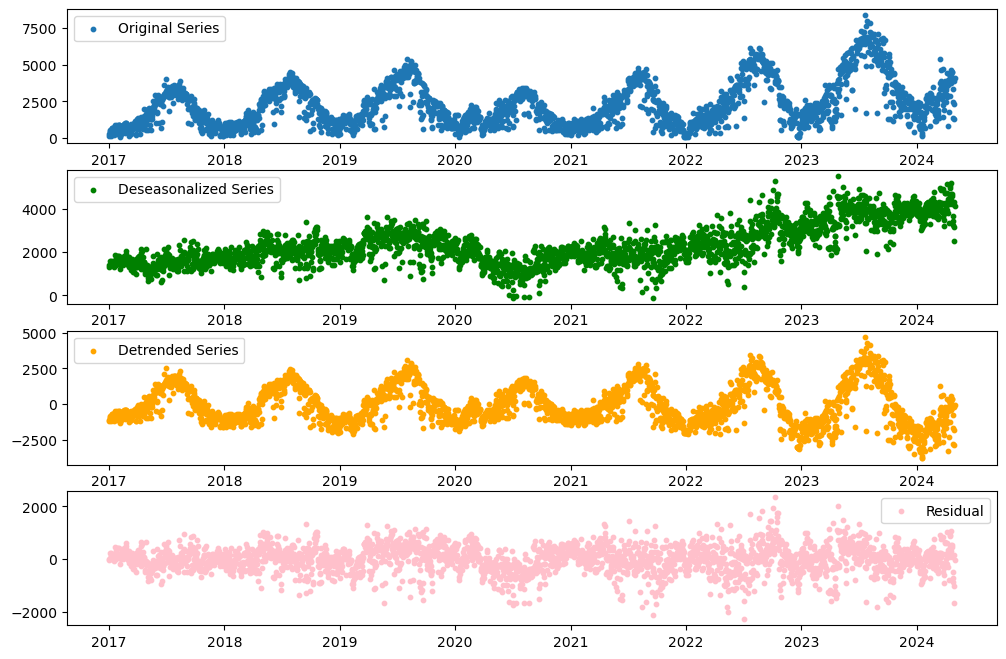

In [9]:
# Plot the original series, detrended series, and deseasonalized series
plt.figure(figsize=(12, 8))

# Original time series
plt.subplot(4, 1, 1)
plt.scatter(df.index, df['num_trips'], label='Original Series', s = 10)
plt.legend()

# Desasonalized time series
plt.subplot(4, 1, 2)
plt.scatter(df.index, deseasonalized, label='Deseasonalized Series', color='green', s = 10)
plt.legend()

# Detrended time series
plt.subplot(4, 1, 3)
plt.scatter(df.index, detrended, label='Detrended Series', color='orange', s = 10)
plt.legend()

# The residual
plt.subplot(4, 1, 4)
plt.scatter(df.index, residual, label='Residual', color='pink', s = 10)
plt.legend()
plt.show()

In [10]:
# Add the newly detrended data to the training set
train_df['detrend_STL'] = detrended[:len(train_df)]
train_df['trend_STL'] = trend[:len(train_df)]

## Comparing different detrending methods

In [11]:
# Our training set with four different detrending methods
train_df.head()

,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,total_precip,...,total_duration,ebike_trips,num_trips,detrend_poly3,detrend_scaling,trend_scaling,detrend_pcws,trend_pcws,detrend_STL,trend_STL
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,497.133333,-2.3,2.2,-0.1,4.5,18.1,0.0,0.0,0.0,0.0,...,232693.0,0.0,162,1480.333252,-1539.243403,1701.243403,-1323.585558,1485.585558,-1218.004632,1380.004632
2017-01-02,498.133333,-6.0,1.4,-2.3,7.4,20.3,0.0,0.0,0.0,0.0,...,382729.0,0.0,270,1588.333252,-1431.675809,1701.675809,-1216.380736,1486.380736,-1110.987367,1380.987367
2017-01-03,499.133333,-7.8,0.4,-3.7,8.2,21.7,0.0,0.0,0.0,0.0,...,376013.0,0.0,384,1702.333252,-1318.108215,1702.108215,-1103.175913,1487.175913,-997.970892,1381.970892
2017-01-04,501.133333,-8.4,2.2,-3.1,10.6,21.1,0.0,0.0,0.0,0.0,...,376721.0,0.0,460,1778.333252,-1242.540622,1702.540622,-1027.971091,1487.971091,-922.955207,1382.955207
2017-01-05,502.133333,-6.6,0.7,-3.0,7.3,21.0,0.0,0.0,0.0,0.0,...,524933.0,0.0,524,1842.333252,-1178.973028,1702.973028,-964.766269,1488.766269,-859.940317,1383.940317


Let's visualize the effects of different detrending methods. 

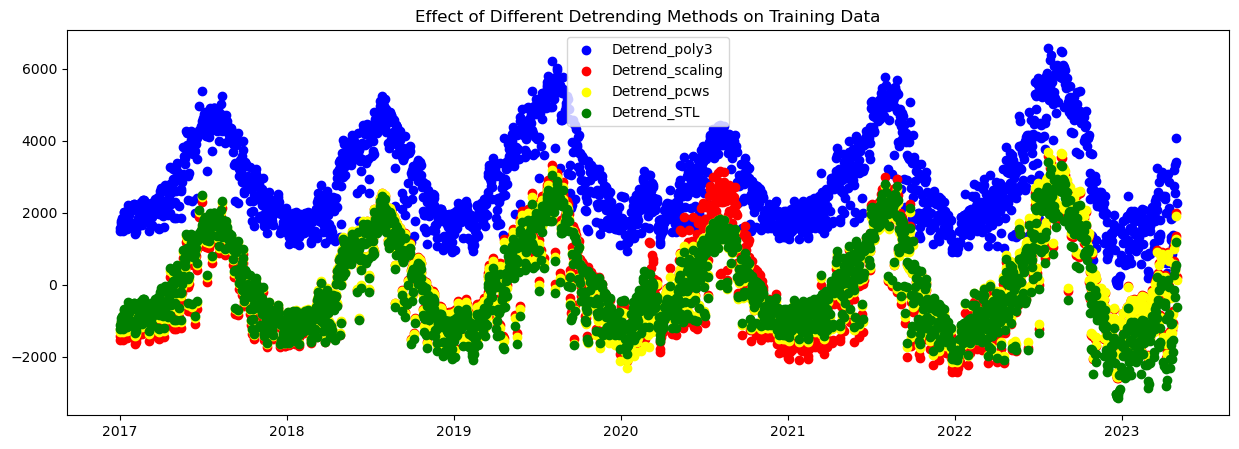

In [12]:
train_dates = train_df.index

plt.figure(figsize=(15, 5))
plt.scatter(train_dates, train_df['detrend_poly3'], label='Detrend_poly3', color = 'blue')
plt.scatter(train_dates, train_df['detrend_scaling'], label='Detrend_scaling', color = 'red')
plt.scatter(train_dates, train_df['detrend_pcws'], label='Detrend_pcws', color = 'yellow')
plt.scatter(train_dates, train_df['detrend_STL'], label='Detrend_STL', color = 'green')

plt.title('Effect of Different Detrending Methods on Training Data')
plt.legend()
plt.show()


As we can see, Methods 2 to 4 are quite similar, and all differ from Method 1 by a shift.

## Test Data (2023/05/01 - 2024/04/30)


We perform the same task (adding different versions of detrended data) for the test set.

In [13]:
# Loading in the test data
test_df =  pd.read_csv('bikeshare_test_data_v1.csv',parse_dates=['Date'])

# Use dates as indices
test_df.set_index(test_df['Date'], inplace=True)
test_df.drop(columns=['Date','Unnamed: 0'], inplace=True)

# Rename the columns based on detrending methods
test_df.rename(columns={"adj_num_trips": "detrend_scaling", "trend":"trend_scaling"}, inplace =True)

# Add the detrended data via piecewise linear regressions
df4 = pd.read_csv('bikeshare_test_data_v2.csv',parse_dates=['Date'])
df4.set_index(df4['Date'], inplace=True)
test_df['detrend_pcws'] = df4['adj_num_trips']
test_df['trend_pcws'] = df4['trend']

# Add the detrended data using STL
test_df['detrend_STL'] = detrended[-len(test_df):]
test_df['trend_STL'] = trend[-len(test_df): ]

In [14]:
test_df.head()

,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,total_precip,...,total_dist,total_duration,ebike_trips,num_trips,detrend_scaling,trend_scaling,detrend_pcws,trend_pcws,detrend_STL,trend_STL
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-01,878.233333,8.2,14.3,11.3,6.1,6.7,0.0,0.0,0.0,0.0,...,8845978.00,4189598.0,940.0,3323,622.465708,2700.534292,537.645162,2785.354838,-190.698676,3513.698676
2023-05-02,881.233333,9.2,16.9,13.1,7.7,4.9,0.0,0.0,0.0,0.0,...,14330668.34,6003918.0,1415.0,4829,2128.033302,2700.966698,2042.479970,2786.520030,1313.480324,3515.519676
2023-05-03,884.233333,11.4,18.7,15.1,7.3,2.9,0.0,0.0,0.0,0.0,...,14161604.00,6968794.0,1384.0,4788,2086.600895,2701.399105,2000.314777,2787.685223,1270.663349,3517.336651
2023-05-04,887.233333,11.7,19.1,15.4,7.4,2.6,0.0,0.0,0.0,0.0,...,12494360.00,6720056.0,1289.0,4364,1662.168489,2701.831511,1575.149585,2788.850415,844.850229,3519.149771
2023-05-05,890.233333,9.8,12.4,11.1,2.6,6.9,0.0,15.6,0.0,15.6,...,3639263.67,1390702.0,472.0,1571,-1131.263917,2702.263917,-1219.015607,2790.015607,-1949.959214,3520.959214


and visualize the effects

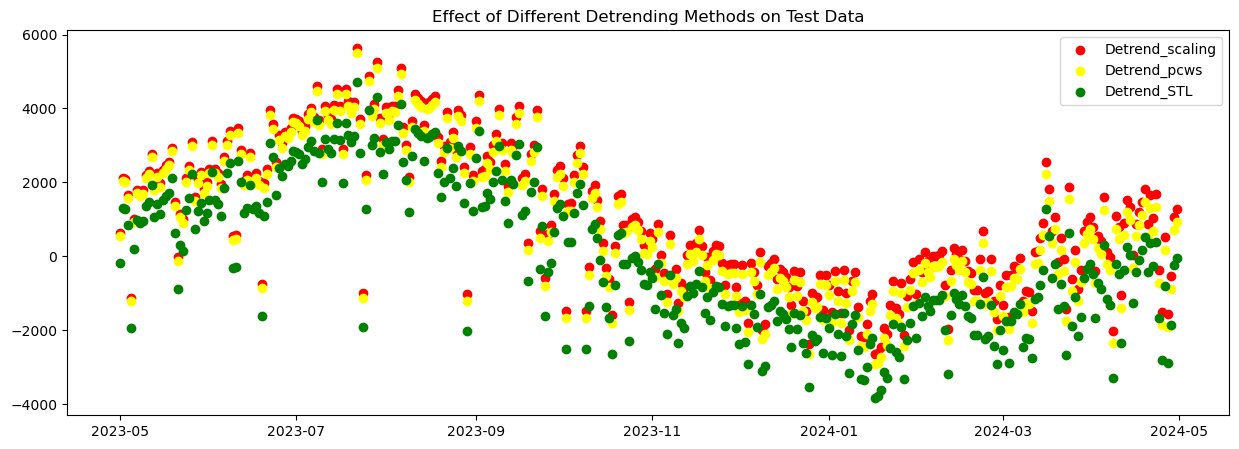

In [15]:
test_dates = test_df.index

plt.figure(figsize=(15, 5))
#plt.scatter(test_dates, test_df['detrend_poly3'], label='Detrend_poly3', color = 'blue')
plt.scatter(test_dates, test_df['detrend_scaling'], label='Detrend_scaling', color = 'red')
plt.scatter(test_dates, test_df['detrend_pcws'], label='Detrend_pcws', color = 'yellow')
plt.scatter(test_dates, test_df['detrend_STL'], label='Detrend_STL', color = 'green')

plt.title('Effect of Different Detrending Methods on Test Data')
plt.legend()
plt.show()

# Testing different models

In [16]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

 The following function compares different modeling approaches

- The ``model`` argument takes a model object, e.g., LinearRegression, KNN
- The variable ``X_train`` depends on how we select the features 
- The variable ``y_train`` depends on how we detrend the data
- ``n`` is the number of cross-validations

The function returns the average root MSE over the validation sets, predicted values, and the residues.

In [62]:
def test(model, X_train, y_train, n):
    
    kfold = KFold(n_splits = n, shuffle = True, random_state = 416)
    total_rmse = 0
    
    for train_index, test_index in kfold.split(X_train):
    
        X_tt = X_train.iloc[train_index]
        y_tt = y_train.iloc[train_index]
    
        X_val = X_train.iloc[test_index]
        y_val = y_train.iloc[test_index]
    
        ## Fit the model
        model.fit(X_tt,y_tt)

        # Make the prediction
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        total_rmse += rmse

    predict_values = model.predict(X_train)
    residues = y_train - model.predict(X_train)
    
    return total_rmse/n, model.predict(X_train), residues

## Preliminary models

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor

In [47]:
# Make a linear regression model
reg = LinearRegression()

# Make some ridge and lasso regression models
alphas=  [0.000001,.00001,.0001,.001,.01,.1,.25,.5,.75,1,5,10,25,50,100,1000,10000]
ridge_models = [Ridge(alpha = alpha_val) for alpha_val in alphas]
lasso_models = [Lasso(alpha = alpha_val) for alpha_val in alphas]

# Make some KNR models
knrs = [KNeighborsRegressor(i) for i in list(range(2, 50))]

# Make a list of models
models = [reg] + ridge_models + lasso_models + knrs

## Defining ``X_train`` and ``y_train``

In [20]:
from sklearn.preprocessing import StandardScaler

In [99]:
features = ['day_length','max_temp', 'temp_diff', 'total_precip','max_gust']

In [100]:
X_train = train_df[features].copy()

# Scale the data
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled['day_length_x_max_temp'] = X_train_scaled['day_length'] * X_train_scaled['max_temp']

# The y_train values corresponding to different detrending methods
y_trains = [train_df['detrend_poly3'], train_df['detrend_scaling'],train_df['detrend_pcws'], train_df['detrend_STL']]

## Testing the models (using 5-fold cross validations)

In [101]:
# Make a table of average rmses
rmse_table = pd.DataFrame()

for i, y_train in enumerate(y_trains):
    rmses = [test(model, X_train_scaled, y_train, 5)[0] for model in models]
    rmse_table[f'y_train_{i+1}'] = rmses
    rmse_table.index = [f'model_{i+1}' for i in range(len(models))]

In [102]:
rmse_table

,y_train_1,y_train_2,y_train_3,y_train_4
model_1,568.556700,575.402413,521.460105,529.816229
model_2,568.556700,575.402413,521.460105,529.816229
model_3,568.556700,575.402413,521.460105,529.816229
model_4,568.556700,575.402413,521.460104,529.816229
model_5,568.556697,575.402408,521.460101,529.816226
...,...,...,...,...
model_79,537.136223,531.178558,485.495898,496.567889
model_80,537.443242,531.214852,485.577842,496.882199
model_81,537.558230,531.820452,485.814264,497.038445
model_82,537.968516,532.482902,486.161535,497.500312


In [103]:
# Finding the minimum rmse and its index
min_value = rmse_table.min().min()
min_index = rmse_table.stack().idxmin()

print(f'The model with the least average root MSE is {min_index}. Its average RMSE is {min_value:.4f}')

The model with the least average root MSE is ('model_49', 'y_train_3'). Its average RMSE is 474.0441


In [104]:
models[48]

KNeighborsRegressor(n_neighbors=15)

## Plotting the predicted values and the residues

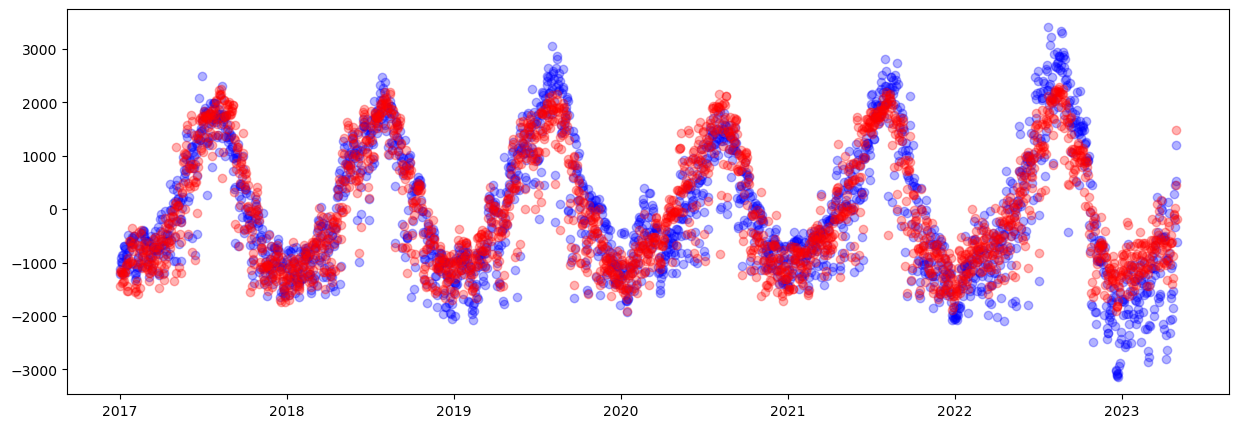

In [105]:
nice_model = models[48]

model_data = test(nice_model, X_train_scaled, y_trains[3], 5)

plt.figure(figsize=(15, 5))
plt.scatter(X_train_scaled.index, y_train, label='Actual', color = 'blue', alpha = 0.3)
plt.scatter(X_train_scaled.index, model_data[1], label='Predicted', color='red', alpha = 0.3)
plt.show()

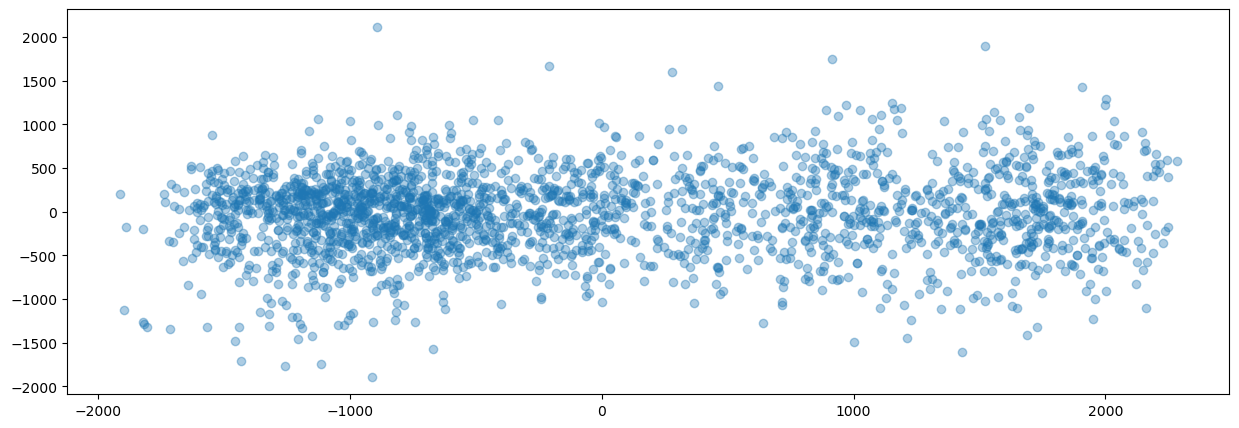

In [106]:
plt.figure(figsize=(15, 5))
plt.scatter(model_data[1], model_data[2], alpha = 0.37)
plt.show()

## Performance on the testing data

In [110]:
X_test = test_df[features].copy()
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled['day_length_x_max_temp'] = X_test_scaled['day_length'] * X_test_scaled['max_temp']

pred_val = nice_model.predict(X_test_scaled) + test_df['trend_STL']

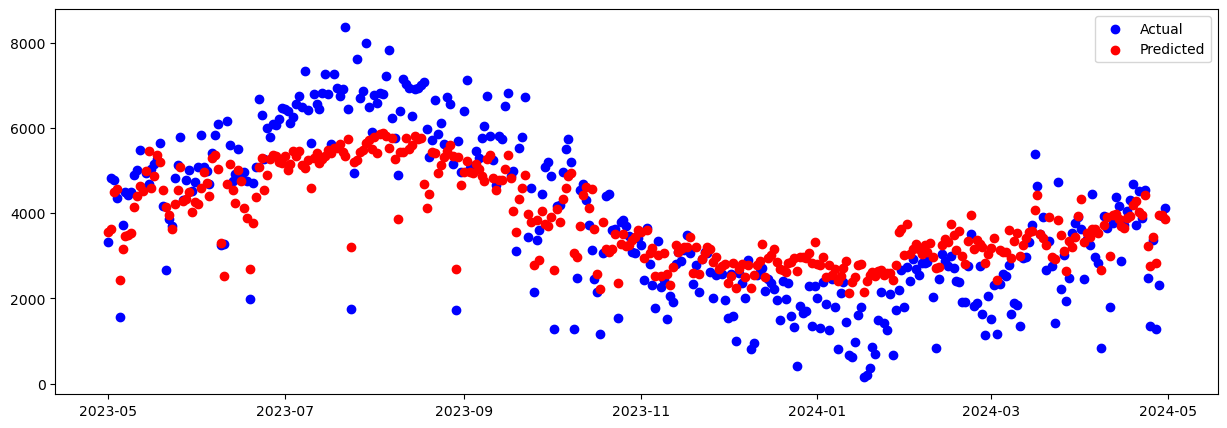

In [111]:
plt.figure(figsize=(15, 5))
plt.scatter(X_test.index, test_df['num_trips'], label='Actual', color = 'blue')
plt.scatter(X_test.index, pred_val, label='Predicted', color='red')
plt.legend()
plt.show()

In [112]:
np.sqrt(mean_squared_error(pred_val, test_df['num_trips']))

981.9032933407718